In [15]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Packages for quantum stuff
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeBrisbane, FakeSherbrooke # For simulation with realistic noise

objective_func_vals = []
numOptimisations = 0 # Tracks iterations within a single minimize call

In [16]:
def load_qubo_and_build_hamiltonian(file_path="qubo_data.json"):
    """
    Loads QUBO terms, weights, and constant from a JSON file.
    Determines the number of qubits from the terms and constructs
    the Hamiltonian as a Qiskit SparsePauliOp.
    """
    with open(file_path, "r") as f:
        qubo_data = json.load(f)

    terms = qubo_data["terms"]
    weights = qubo_data["weights"]
    constant = qubo_data.get("constant", 0.0)
    problemType = qubo_data.get("problem_type")

    pauli_list = []
    num_qubits = 0

    if terms:
        # Flatten the list of lists and filter out empty sublists or non-integer elements
        all_indices = []
        for term_group in terms:
            if isinstance(term_group, list): # Ensure it's a list
                for idx in term_group:
                    if isinstance(idx, int): # Ensure index is an integer
                        all_indices.append(idx)

        if all_indices: # If there are any valid integer indices
            num_qubits = max(all_indices) + 1
        else: # No indices and no weights (only constant)
            num_qubits = 0
    else: # No terms at all
        num_qubits = 0
        if weights: # Weights present but no terms - problematic
            print("Warning: Weights are present, but 'terms' list is empty or missing. Cannot form Pauli operators.")

    for term_indices, weight in zip(terms, weights):
        if not term_indices or not all(isinstance(idx, int) for idx in term_indices):
            # Skip if term_indices is empty or contains non-integers
            continue

        paulis_arr = ["I"] * num_qubits
        if len(term_indices) == 1: # Linear term
            paulis_arr[term_indices[0]] = "Z"
        elif len(term_indices) == 2: # Quadratic term
            paulis_arr[term_indices[0]] = "Z"
            paulis_arr[term_indices[1]] = "Z"
        else:
            # This case should ideally not be hit if terms are only single or pairs.
            print(f"Warning: Skipping term {term_indices} with unsupported number of variables for Pauli Z construction.")
            continue
        pauli_list.append(("".join(paulis_arr)[::-1], weight))

    if not pauli_list and num_qubits > 0: # No valid Pauli terms were created, but num_qubits > 0
        cost_hamiltonian = SparsePauliOp(["I"] * num_qubits, [0]) # Zero operator on n_qubits
    elif not pauli_list and num_qubits == 0:
        cost_hamiltonian = SparsePauliOp("I", [0]) # Placeholder for 1 qubit if everything is empty
    else:
        cost_hamiltonian = SparsePauliOp.from_list(pauli_list)

    return cost_hamiltonian, constant, num_qubits, problemType

def cost_func_estimator(params, ansatz, estimator, cost_hamiltonian_logical, constant_offset, backend_total_qubits=127): # removed default for backend_total_qubits
    global numOptimisations
    prepared_observable = cost_hamiltonian_logical.apply_layout(ansatz.layout)
    pub = (ansatz, prepared_observable, [params])
    
    job = estimator.run(pubs=[pub])
    results = job.result()[0]
    cost = results.data.evs[0]

    cost_float = float(np.real(cost)) + constant_offset
    objective_func_vals.append(cost_float)
    
    numOptimisations = numOptimisations + 1
    # Your desired print format:
    print(f"Params: {params}, Cost: {cost_float}, Optimisation Round: {numOptimisations}") 
    
    return cost_float

In [17]:
cost_hamiltonian, constant_offset, num_qubits, problem_type = load_qubo_and_build_hamiltonian("qubo_data.json")
print("Cost Function Hamiltonian (from QUBO):", cost_hamiltonian)
print("Constant offset:", constant_offset)
print(f"Number of qubits (inferred from terms): {num_qubits}")
print("Problem type:", problem_type)

Cost Function Hamiltonian (from QUBO): SparsePauliOp(['IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'IIIZZI', 'IIZIZI', 'ZIIIZI', 'IZIZII', 'ZIIZII', 'ZIZIII', 'ZZIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])
Constant offset: 0
Number of qubits (inferred from terms): 6
Problem type: maximum_cut


In [18]:
#backend_simulator = AerSimulator.from_backend(FakeSherbrooke())
backend_simulator = AerSimulator() # Ideal simulator for use getting the script to work
estimator = Estimator(mode=backend_simulator)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend_simulator)

In [19]:
# 3. Iteration and Optimization
depth_list = [1,2,3,4,5,6,7,8]
repetitions_per_depth = 3
average_costs_by_depth = {}
current_repetition_num = 0

In [ ]:
for p_depth in depth_list:
    print(f"\n--- Optimizing for Depth (reps_p): {p_depth} ---")
    costs_for_this_depth = []
    circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p_depth)
    circuit.measure_all() 
    candidate_circuit = pm.run(circuit)
    print(f"  Circuit for depth {p_depth} created. Num params: {2*p_depth}. Transpiled depth: {candidate_circuit.depth()}")
    for rep_n in range(repetitions_per_depth):
        current_repetition_num = rep_n # Make it accessible to cost_func_estimator via global
        print(f" Repetition {rep_n + 1}/{repetitions_per_depth} for depth {p_depth}")
        # Reset globals for each minimize call
        objective_func_vals = []
        numOptimisations = 0
        num_params = 2 * p_depth
        initial_betas = (np.random.rand(p_depth) * np.pi).tolist()
        #initial_gammas = (np.random.rand(p_depth) * (np.pi / 2)).tolist() #the /2 is a relic from the utility scale example that doesnt seem needed
        initial_gammas = (np.random.rand(p_depth) * (np.pi)).tolist()
        initial_params = initial_betas + initial_gammas #order expected by qaoaansataz() is [betas, gammas]
        print(f"  Initial params (random): {np.round(initial_params,2)}")
        result = minimize(
            cost_func_estimator,
            initial_params,
            args=(candidate_circuit, estimator, cost_hamiltonian, constant_offset),
            method="COBYLA",
            tol=1e-3,       # Can be adjusted
            options={"maxiter": 1000} # Max iterations for COBYLA per run
        )
        print(f"  Rep {rep_n + 1} Result: Optimal Cost = {result.fun:.4f}")
        costs_for_this_depth.append(result.fun)
    average_cost = np.mean(costs_for_this_depth)
    average_costs_by_depth[p_depth] = average_cost
    print(f"--- Average cost for depth {p_depth} over {len(costs_for_this_depth)} successful runs: {average_cost:.4f} ---")



--- Optimizing for Depth (reps_p): 1 ---
  Circuit for depth 1 created. Num params: 2. Transpiled depth: 10
 Repetition 1/3 for depth 1
  Initial params (random): [2.01 0.34]
Params: [2.0125974  0.33611065], Cost: 4.90185546875, Optimisation Round: 1
Params: [3.0125974  0.33611065], Cost: -1.5576171875, Optimisation Round: 2
Params: [3.0125974  1.33611065], Cost: -0.44140625, Optimisation Round: 3
Params: [3.99799337 0.16583208], Cost: 0.20556640625, Optimisation Round: 4
Params: [3.50529539 0.25097137], Cost: 4.33642578125, Optimisation Round: 5
Params: [2.76364479 0.31325025], Cost: -2.54052734375, Optimisation Round: 6
Params: [2.70942004 0.55729876], Cost: -0.87109375, Optimisation Round: 7
Params: [2.66485337 0.08359778], Cost: -1.3251953125, Optimisation Round: 8
Params: [2.71424908 0.19842401], Cost: -2.3076171875, Optimisation Round: 9
Params: [2.71722128 0.35509648], Cost: -2.0673828125, Optimisation Round: 10
Params: [2.82497782 0.30122903], Cost: -2.67626953125, Optimisatio


--- Final Results ---
Average costs by depth: {1: -2.2705078125, 2: -2.4402669270833335, 3: -2.451171875, 4: -2.5520833333333335, 5: -3.0631510416666665, 6: -2.8951822916666665, 7: -2.6868489583333335, 8: -3.0613606770833335}


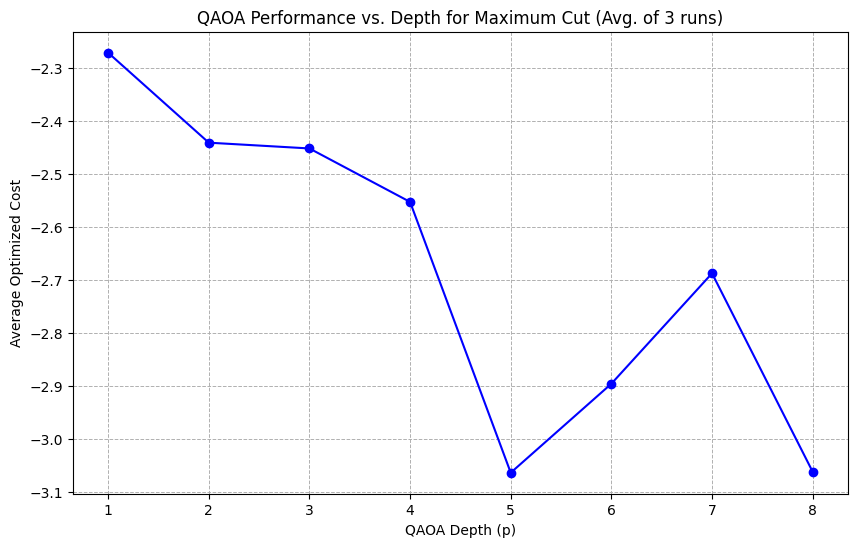

In [23]:
print("\n--- Final Results ---")
print("Average costs by depth:", average_costs_by_depth)

depths = sorted(average_costs_by_depth.keys())
avg_costs = [average_costs_by_depth[d] for d in depths]

plt.figure(figsize=(10, 6))
plt.plot(depths, avg_costs, marker='o', linestyle='-', color='b')
plt.xlabel("QAOA Depth (p)")
plt.ylabel("Average Optimized Cost")
plt.title(f"QAOA Performance vs. Depth for {problem_type.replace('_', ' ').title()} (Avg. of {repetitions_per_depth} runs)")
plt.xticks(depth_list) # Ensure all depths in the list are shown as ticks
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.show()